Fit CNN in PyTorch
===


## Imports

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets, models, transforms, utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import copy
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import cv2
from skimage import io, transform
from glob import glob


device = 'cuda' if torch.cuda.is_available() else 'cpu'


# number of models
n_ensemble = 2

# Number of dimensions in the dataset
n_dim = 8

# Batch size for training (change depending on how much memory you have)
batch_size_im = 90
batch_size_ft = 30

# Number of epochs to train for 
num_epochs_im = 15
num_epochs_ft = 15

# where would we use these in pytorch? in keras they are used to create layers for the intermediate model
dropout = 0.5   
n_dense = 256
n_layers = 2

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract_im = True
feature_extract_ft = False

input_size = 224

loglr = -2.2200654426745987
lr_im = 1.2 * 10 ** loglr
lr_ft = 0.0001

IMG_360 = "../sanders_2018/360 Rocks"
IMG_120 = '../sanders_2018/120 Rocks'
MDS_360 = "../finetuning_torchvision_data/mds_360.csv"
PATH_IM = 'CNN_checkpoints/state_dict_intermediate_model.pt'
PATH_FT = 'CNN_checkpoints/state_dict_finetuned_model.pt'

## Functions and classes

In [70]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=14, is_inception=False):
    """
    handles the training and validation of a given model. At the end of
    training returns the best performing model. After each epoch, the training and validation
    accuracies are printed
    """
    
    since = time.time()

    val_acc_history = []
    lrs = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = None
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_r2 = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    score = r2_score(labels.detach().numpy(), outputs.detach().numpy())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        lr = optimizer.param_groups[0]["lr"]
                        lrs.append(lr)

                # statistics 
                running_loss += loss.item() * inputs.size(0)
                running_r2 += score.item() * inputs.size(0)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset) 
            epoch_acc = running_r2 / len(dataloaders[phase].dataset) 

            print(f'{phase} Loss: {epoch_loss: .4f} Acc: {epoch_acc: .4f} lr: {lr: .4e}')

            # deep copy the model
            if phase == 'val' and best_acc == None:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and best_acc < epoch_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        
        print() # empty line between epochs

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, lrs


def set_parameter_requires_grad(model, feature_extracting):
    """
    This helper function sets the ``.requires_grad`` attribute of the
    parameters in the model to False when we are feature extracting.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
        for param in model.parameters():
            param.requires_grad = True
    return None


class RocksData(datasets.VisionDataset):
    def __init__(self, df, root_dir):
        super(RocksData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
        self.root_dir = root_dir
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        img_path = self.root_dir + "/" + self.df.iloc[ix,0]
        img = cv2.imread(img_path)/255.
        label = deepcopy(self.df.iloc[ix,1:].tolist())
        label = torch.tensor(label).float()
        img = self.preprocess_input(img)
        return img, label
    def preprocess_input(self, img):
        img = cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device)    

def get_criterion(loss_name):
    """
    Returns the optimizer
    """
    if loss_name == "L1":
        return torch.nn.L1Loss()
    elif loss_name == "L2":
        return torch.nn.MSELoss()
    elif loss_name == "smooth_L1":
        return torch.nn.SmoothL1Loss()
    elif loss_name == "huber":
        return torch.nn.HuberLoss()
    else:
        raise Exception("No valid loss_name entered!")

## Load Data

In [71]:
df = pd.read_csv(MDS_360)

train, test = train_test_split(df, test_size=90, random_state=0)
train_dataset = RocksData(train.reset_index(drop=True), IMG_360)
test_dataset = RocksData(test.reset_index(drop=True), IMG_360)

## Define final layers

This is how the final layers look like in Keras:

```
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================

avg_pool (GlobalAveragePooling  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 2D)                                                                                              
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['avg_pool[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['dropout[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256)         1024        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout_1 (Dropout)            (None, 256)          0           ['batch_normalization[0][0]']    
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dropout_1[0][0]']              
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256)         1024        ['dense_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dropout_2 (Dropout)            (None, 256)          0           ['batch_normalization_1[0][0]']  
                                                                                                  
 dense_2 (Dense)                (None, 8)            2056        ['dropout_2[0][0]']       
```

In [72]:
def get_output_layers(dropout, num_ftrs, n_dim, n_layers):
    """
    Returns the output layers.
    """
   
    output = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_ftrs, n_dense), # dense in keras
            nn.ReLU(inplace=True), # dense
            nn.BatchNorm1d(n_dense),
            nn.Dropout(p=dropout),
            nn.Linear(n_dense, n_dense), # dense
            nn.ReLU(inplace=True), # dense
            nn.BatchNorm1d(n_dense),
            nn.Dropout(p=dropout),
            nn.Linear(n_dense, n_dim) # dense
        )
    
    return output

## Train finetuned model only

## Train ensemble

Epoch 1/15
----------
train Loss:  6.7069 Acc: -0.0470 lr:  7.2296e-03
val Loss:  7.0908 Acc: -0.0564 lr:  7.2296e-03

Epoch 2/15
----------
train Loss:  4.1844 Acc:  0.3241 lr:  7.2296e-03
val Loss:  8.0200 Acc: -0.2552 lr:  7.2296e-03

Epoch 3/15
----------
train Loss:  3.5777 Acc:  0.4229 lr:  7.2296e-03
val Loss:  5.9221 Acc: -0.0373 lr:  7.2296e-03

Epoch 4/15
----------
train Loss:  3.2383 Acc:  0.4748 lr:  7.2296e-03
val Loss:  4.5940 Acc:  0.1678 lr:  7.2296e-03

Epoch 5/15
----------
train Loss:  2.9643 Acc:  0.5219 lr:  7.2296e-03
val Loss:  4.1496 Acc:  0.2579 lr:  7.2296e-03

Epoch 6/15
----------
train Loss:  2.7924 Acc:  0.5463 lr:  7.2296e-03
val Loss:  3.5641 Acc:  0.3786 lr:  7.2296e-03

Epoch 7/15
----------
train Loss:  2.7012 Acc:  0.5642 lr:  7.2296e-03
val Loss:  2.8654 Acc:  0.5127 lr:  7.2296e-03

Epoch 8/15
----------
train Loss:  2.5495 Acc:  0.5860 lr:  7.2296e-03
val Loss:  2.5455 Acc:  0.5679 lr:  7.2296e-03

Epoch 9/15
----------
train Loss:  2.4847 Acc:  

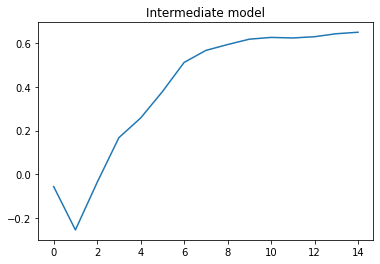

Epoch 1/15
----------
train Loss:  2.4000 Acc:  0.5916 lr:  8.0000e-04
val Loss:  2.0804 Acc:  0.6445 lr:  8.0000e-04

Epoch 2/15
----------
train Loss:  2.3241 Acc:  0.6043 lr:  8.0000e-04
val Loss:  2.1158 Acc:  0.6402 lr:  8.0000e-04

Epoch 3/15
----------
train Loss:  2.4969 Acc:  0.5771 lr:  8.0000e-04
val Loss:  2.1391 Acc:  0.6372 lr:  8.0000e-04

Epoch 4/15
----------
train Loss:  2.3012 Acc:  0.6134 lr:  8.0000e-04
val Loss:  2.1686 Acc:  0.6336 lr:  8.0000e-04

Epoch 5/15
----------
train Loss:  2.3346 Acc:  0.6051 lr:  8.0000e-04
val Loss:  2.1448 Acc:  0.6362 lr:  8.0000e-04

Epoch 6/15
----------
train Loss:  2.4178 Acc:  0.5886 lr:  8.0000e-04
val Loss:  2.1313 Acc:  0.6381 lr:  8.0000e-04

Epoch 7/15
----------
train Loss:  2.2862 Acc:  0.6220 lr:  8.0000e-04
val Loss:  2.1231 Acc:  0.6400 lr:  8.0000e-04

Epoch 8/15
----------
train Loss:  2.3354 Acc:  0.6093 lr:  8.0000e-04
val Loss:  2.0937 Acc:  0.6438 lr:  8.0000e-04

Epoch 9/15
----------
train Loss:  2.3220 Acc:  

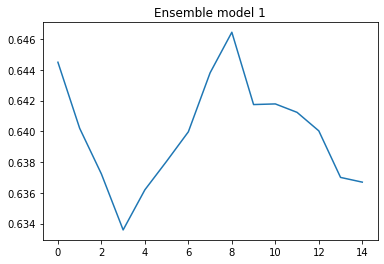

Epoch 1/15
----------
train Loss:  6.3742 Acc:  0.0010 lr:  7.2296e-03
val Loss:  6.5278 Acc:  0.0394 lr:  7.2296e-03

Epoch 2/15
----------
train Loss:  4.3716 Acc:  0.2989 lr:  7.2296e-03
val Loss:  7.2225 Acc: -0.1462 lr:  7.2296e-03

Epoch 3/15
----------
train Loss:  3.6390 Acc:  0.4035 lr:  7.2296e-03
val Loss:  5.1944 Acc:  0.1280 lr:  7.2296e-03

Epoch 4/15
----------
train Loss:  3.3572 Acc:  0.4561 lr:  7.2296e-03
val Loss:  5.2770 Acc:  0.0407 lr:  7.2296e-03

Epoch 5/15
----------
train Loss:  2.9854 Acc:  0.5170 lr:  7.2296e-03
val Loss:  4.5391 Acc:  0.1665 lr:  7.2296e-03

Epoch 6/15
----------
train Loss:  2.8311 Acc:  0.5405 lr:  7.2296e-03
val Loss:  3.6658 Acc:  0.3360 lr:  7.2296e-03

Epoch 7/15
----------
train Loss:  2.7621 Acc:  0.5505 lr:  7.2296e-03
val Loss:  2.8639 Acc:  0.5059 lr:  7.2296e-03

Epoch 8/15
----------
train Loss:  2.6653 Acc:  0.5730 lr:  7.2296e-03
val Loss:  2.5176 Acc:  0.5739 lr:  7.2296e-03

Epoch 9/15
----------
train Loss:  2.5501 Acc:  

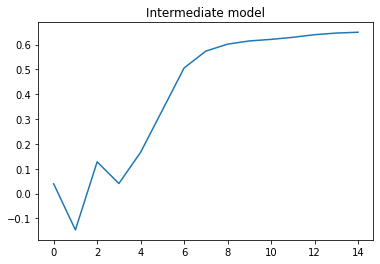

Epoch 1/15
----------
train Loss:  2.3368 Acc:  0.6059 lr:  8.0000e-04
val Loss:  2.1012 Acc:  0.6409 lr:  8.0000e-04

Epoch 2/15
----------
train Loss:  2.2850 Acc:  0.6180 lr:  8.0000e-04
val Loss:  2.1330 Acc:  0.6369 lr:  8.0000e-04

Epoch 3/15
----------
train Loss:  2.3592 Acc:  0.6044 lr:  8.0000e-04
val Loss:  2.1351 Acc:  0.6366 lr:  8.0000e-04

Epoch 4/15
----------
train Loss:  2.2766 Acc:  0.6147 lr:  8.0000e-04
val Loss:  2.1485 Acc:  0.6342 lr:  8.0000e-04

Epoch 5/15
----------
train Loss:  2.3161 Acc:  0.6134 lr:  8.0000e-04
val Loss:  2.1493 Acc:  0.6327 lr:  8.0000e-04

Epoch 6/15
----------
train Loss:  2.3123 Acc:  0.6089 lr:  8.0000e-04
val Loss:  2.1348 Acc:  0.6337 lr:  8.0000e-04

Epoch 7/15
----------
train Loss:  2.3442 Acc:  0.6045 lr:  8.0000e-04
val Loss:  2.1516 Acc:  0.6320 lr:  8.0000e-04

Epoch 8/15
----------
train Loss:  2.2613 Acc:  0.6153 lr:  8.0000e-04
val Loss:  2.1482 Acc:  0.6325 lr:  8.0000e-04

Epoch 9/15
----------
train Loss:  2.1835 Acc:  

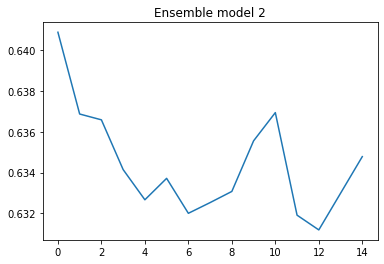

In [74]:
for e in range(1, n_ensemble + 1):
       
    # Intermediate model
    model = models.resnet50(pretrained=True)
    set_parameter_requires_grad(model, feature_extract_im)
    num_ftrs = model.fc.in_features
    new_layers = get_output_layers(dropout, num_ftrs, n_dim, n_layers)
    model.fc = new_layers # last fully connected layer
    
    # Send the model to GPU
    model = model.to(device)
    
    # create datalaoders with specific batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size_im)
    test_loader = DataLoader(test_dataset, batch_size=batch_size_im)
    dataloaders_dict = {"train":train_loader,"val":test_loader}
    
    # Create Optimizer and define params to update
    params_to_update = model.parameters()
    if feature_extract_im:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                #print("\t",name)

    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                #print("\t",name)
                ...


    # Instantiate optimizer for intermediate model
    optimizer = optim.Adam(params_to_update, lr = lr_im)
    
    # Setup the loss fxn
    criterion = get_criterion('L2')
    
    # Initial training and evaluate
    model, hist, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs_im)
    
    # Plot learning curve
    plt.plot(hist)
    plt.title('Intermediate model')
    plt.show()
    
    # Save intermediate model
    torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, PATH_IM)

    # fine tuning
    
    # create datalaoders with specific batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size_ft)
    test_loader = DataLoader(test_dataset, batch_size=batch_size_ft)
    dataloaders_dict = {"train":train_loader,"val":test_loader}
            
    # Create Optimizer and define params to update
    params_to_update = model.parameters()
    if feature_extract_ft:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                #print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                #print("\t",name)
                ...

    # Instantiate optimizer for finetuning
    optimizer = optim.SGD(params_to_update, lr = lr_ft, momentum = 0.9)
    
    # Setup the loss fxn
    criterion = get_criterion("L2")

    # Train and evaluate fine tuned model
    model, hist, lrs = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs_ft)
    
    # Plot learning curve
    plt.plot(hist)
    plt.title(f'Ensemble model {e}')
    plt.show()
    
    # Save intermediate model
    PATH_EN = f'CNN_checkpoints/state_dict_ensemble_model_{e}.pt'
    torch.save(model.state_dict(), PATH_EN)

## Predictions

#### Load model

In [ ]:
# OPTIONAL: Load pre-trained state
# model = ...
# checkpoint = torch.load(PATH_IM)
# model.load_state_dict(checkpoint['model_state_dict'])

#### Validate and predict functions

In [ ]:
def validate(model, testloader, criterion):
    """Takes test dataloader and returns loss and score"""
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_score = 0
    with torch.no_grad():        
        for i, data in enumerate(testloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(inputs)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            score = r2_score(labels, outputs)
            valid_running_score += score
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / (i+1)
    epoch_acc = valid_running_score / (i+1)

    return epoch_loss, epoch_acc


def predict(model, img_path):
        """Takes model and picture(s) and predicts the MDS coordinates"""
        model.eval()
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
        img = cv2.imread(img_path)/255.
        img = cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = normalize(img).float().unsqueeze(0)
        with torch.no_grad():
            output = model(img.to(device))
            
        return output.squeeze().numpy()

#### Predicting 120 Rocks set

In [ ]:
img_120_files = glob(IMG_120 + '/*')

rocks_120_prediction = []

for img_file in img_120_files:
    rocks_120_prediction.append(predict(model, img_file))

rocks_120_prediction = np.array(rocks_120_prediction)

## Save predictions to file

In [ ]:
cnn_pred_file = "CNN Predictions/MDS Dimensions/cnn_torch_predicted_mds_120.txt"

np.savetxt(cnn_pred_file, rocks_120_prediction)